# Getting Data & Splitting It

In [3]:
import pandas as pd
import numpy as np

# Load the datasets from local files
accepted_loans = pd.read_csv('data/accepted_dropped.csv')
rejected_loans = pd.read_csv('data/rejected_2007_to_2018q4.csv')


/var/folders/my/s67b35452911z7pfqpbhlp5m0000gn/T/ipykernel_16975/4142632862.py:5: DtypeWarning: Columns (18,48,58) have mixed types. Specify dtype option on import or set low_memory=False.
  accepted_loans = pd.read_csv('data/accepted_dropped.csv')


Combined dataset shape: (300000, 1)
Columns: ['target']


# Changing The Columns Of Rejected Loans

In [11]:
column_mapping = {
    'Amount Requested': 'loan_amnt',
    'Application Date': 'issue_d',
    'Loan Title': 'title',
    'Risk_Score': 'fico_range_low',  # or 'fico_range_high' as needed
    'Debt-To-Income Ratio': 'dti',
    'Zip Code': 'zip_code',
    'State': 'addr_state',
    'Employment Length': 'emp_length',
    'Policy Code': 'policy_code'
}

# Rename the columns
rejected_loans_renamed = rejected_loans.rename(columns=column_mapping, inplace=True)

# Cutting The Accepted Loans By Common Columns

In [14]:
selected_columns = [
    'loan_amnt',
    'issue_d',
    'title',
    'fico_range_low',  # or 'fico_range_high' if you prefer
    'dti',
    'zip_code',
    'addr_state',
    'emp_length',
    'policy_code'
]

# Select only these columns from df1
accepted_loans = accepted_loans[selected_columns]

# Getting The Data Together

In [18]:
# Find common columns
common_columns = list(set(accepted_loans.columns) & set(rejected_loans.columns))

# Select common columns
accepted_subset = accepted_loans[common_columns].sample(n=250000, random_state=42)
rejected_subset = rejected_loans[common_columns].sample(n=250000, random_state=42)

# Add a target column to distinguish accepted vs rejected
accepted_subset['target'] = 1
rejected_subset['target'] = 0

# Combine datasets
combined_df = pd.concat([accepted_subset, rejected_subset], ignore_index=True)

# Shuffle the combined dataset
combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Save the combined dataset locally
combined_df.to_csv('data/combined_dataset.csv', index=False)

print("Combined dataset shape:", combined_df.shape)
print("Columns:", combined_df.columns.tolist())

Combined dataset shape: (500000, 10)
Columns: ['emp_length', 'policy_code', 'loan_amnt', 'issue_d', 'zip_code', 'title', 'dti', 'fico_range_low', 'addr_state', 'target']


# Pre-processing Data

In [14]:
df.head()

,emp_length,policy_code,loan_amnt,zip_code,title,dti,fico_range_low,addr_state,target
0,1 year,1.0,8000.0,781xx,Major purchase,20.77,695.0,TX,1
1,10+ years,1.0,8500.0,117xx,Home improvement,29.04,660.0,NY,1
2,4 years,1.0,8125.0,062xx,Debt consolidation,17.58,700.0,CT,1
3,10+ years,1.0,12500.0,018xx,Debt consolidation,14.78,765.0,MA,1
4,5 years,0.0,8000.0,972xx,credit_card,28.33%,NaN,OR,0


# Loading Dataset

In [16]:
df = pd.read_csv('data/combined_dataset.csv')
df.head()

,emp_length,policy_code,loan_amnt,issue_d,zip_code,title,dti,fico_range_low,addr_state,target
0,1 year,1.0,8000.0,2017-02-01,781xx,Major purchase,20.77,695.0,TX,1
1,10+ years,1.0,8500.0,2014-07-01,117xx,Home improvement,29.04,660.0,NY,1
2,4 years,1.0,8125.0,2015-01-01,062xx,Debt consolidation,17.58,700.0,CT,1
3,10+ years,1.0,12500.0,2018-10-01,018xx,Debt consolidation,14.78,765.0,MA,1
4,5 years,0.0,8000.0,2017-03-03,972xx,credit_card,28.33%,NaN,OR,0


# Pre-Processsing Daat

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

# Load the dataset
print("Loading dataset...")
try:
    df = pd.read_csv('data/combined_dataset.csv')
    print(f"Dataset loaded successfully with shape: {df.shape}")
except Exception as e:
    print(f"Error loading dataset: {e}")
    print("Please ensure the path 'data/combined_dataset.csv' is correct.")
    exit(1)

# Display basic information
print("\nFirst 5 rows:")
print(df.head())

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Function to process features in smaller chunks to avoid memory issues
def preprocess_data(df):
    # Create a copy to avoid modifying the original
    processed_df = df.copy()
    
    print("\n1. Processing categorical features...")
    
    # Remove zip_code column completely
    if 'zip_code' in processed_df.columns:
        print("Removing zip_code column (as requested)...")
        processed_df.drop('zip_code', axis=1, inplace=True)
    
    # Process emp_length - convert to ordinal values
    if 'emp_length' in processed_df.columns:
        print("Processing emp_length...")
        # Create mapping based on values seen in the screenshot
        emp_mapping = {
            '< 1 year': 0,
            '1 year': 1, 
            '2 years': 2,
            '3 years': 3,
            '4 years': 4,
            '5 years': 5,
            '6 years': 6,
            '7 years': 7,
            '8 years': 8,
            '9 years': 9,
            '10+ years': 10
        }
        
        # Handle values shown in the screenshot
        # First fill NaN values with a default value
        processed_df['emp_length'].fillna('< 1 year', inplace=True)
        processed_df['emp_length_num'] = 0  # Default value
        
        # Apply mapping for each possible value to avoid errors
        for emp_val, num_val in emp_mapping.items():
            mask = processed_df['emp_length'] == emp_val
            processed_df.loc[mask, 'emp_length_num'] = num_val
            
        # Drop original column
        processed_df.drop('emp_length', axis=1, inplace=True)
    
    # Process issue_d (date)
    if 'issue_d' in processed_df.columns:
        print("Processing issue_d...")
        # Convert to datetime
        processed_df['issue_d'] = pd.to_datetime(processed_df['issue_d'], errors='coerce')
        
        # Extract year and month as separate features
        processed_df['issue_year'] = processed_df['issue_d'].dt.year
        processed_df['issue_month'] = processed_df['issue_d'].dt.month
        
        # Fill NaN values with median values
        year_median = processed_df['issue_year'].median()
        month_median = processed_df['issue_month'].median()
        processed_df['issue_year'].fillna(year_median, inplace=True)
        processed_df['issue_month'].fillna(month_median, inplace=True)
        
        # Drop original date column
        processed_df.drop('issue_d', axis=1, inplace=True)
    
    # Process the 'dti' column to handle percentage values
    if 'dti' in processed_df.columns:
        print("Processing dti column...")
        # Convert percentage strings to float values
        processed_df['dti'] = processed_df['dti'].astype(str).str.replace('%', '', regex=False).astype(float)
        # Fill NaN values with median
        dti_median = processed_df['dti'].median()
        processed_df['dti'].fillna(dti_median, inplace=True)
    
    # One-hot encode categorical columns with limited cardinality
    categorical_cols = ['addr_state']  # Only encode addr_state, skip title due to high cardinality
    categorical_cols = [col for col in categorical_cols if col in processed_df.columns]
    
    if categorical_cols:
        print(f"One-hot encoding categorical features: {categorical_cols}")
        for col in categorical_cols:
            # Fill NaN values first
            processed_df[col].fillna('Unknown', inplace=True)
            
            # Get dummies with a prefix to identify the source column
            dummies = pd.get_dummies(processed_df[col], prefix=col, dummy_na=False)
            
            # Join the encoded columns
            processed_df = pd.concat([processed_df, dummies], axis=1)
            
            # Drop the original column
            processed_df.drop(col, axis=1, inplace=True)
    
    # For the 'title' column, which has too many unique values, apply target encoding
    if 'title' in processed_df.columns:
        print("Applying target encoding to 'title' column to reduce dimensionality")
        # Fill NaN values with a placeholder
        processed_df['title'].fillna('Unknown', inplace=True)
        
        # Calculate the mean target value for each title
        if 'target' in df.columns:
            title_means = processed_df.groupby('title')['target'].mean().to_dict()
            processed_df['title_encoded'] = processed_df['title'].map(title_means)
            # Fill NaN values with the overall mean
            if processed_df['title_encoded'].isna().any():
                mean_target = processed_df['target'].mean()
                processed_df['title_encoded'].fillna(mean_target, inplace=True)
        else:
            # If no target column, just drop title as we can't do proper target encoding
            print("No target column found, dropping 'title' column")
        
        # Drop the original title column
        processed_df.drop('title', axis=1, inplace=True)
    
    print("\n2. Processing numerical features...")
    
    # Handle missing values in numerical columns
    numerical_cols = ['loan_amnt', 'dti', 'fico_range_low']
    numerical_cols = [col for col in numerical_cols if col in processed_df.columns]
    
    if numerical_cols:
        # Print numerical columns and their dtypes to verify they're all numeric
        print("Numerical columns dtypes:")
        print(processed_df[numerical_cols].dtypes)
        
        # Fill NaN values in fico_range_low with median
        if 'fico_range_low' in numerical_cols:
            fico_median = processed_df['fico_range_low'].median()
            processed_df['fico_range_low'].fillna(fico_median, inplace=True)
        
        # Create an imputer for missing values (although we've already filled them)
        imputer = SimpleImputer(strategy='median')
        
        # Apply imputer to numerical columns
        processed_df[numerical_cols] = imputer.fit_transform(processed_df[numerical_cols])
        
        # Scale numerical features
        scaler = StandardScaler()
        processed_df[numerical_cols] = scaler.fit_transform(processed_df[numerical_cols])
    
    print("\n3. Final processing steps...")
    
    # Handle policy_code as a numerical feature
    if 'policy_code' in processed_df.columns:
        print("Processing policy_code as numerical feature...")
        # Fill NaN values with mode
        policy_mode = processed_df['policy_code'].mode()[0]
        processed_df['policy_code'].fillna(policy_mode, inplace=True)
        # Convert to float if not already
        processed_df['policy_code'] = processed_df['policy_code'].astype(float)
        # Add it to our numerical columns for scaling
        
        # Scale policy_code separately since it wasn't in the numerical_cols list
        policy_scaler = StandardScaler()
        processed_df['policy_code'] = policy_scaler.fit_transform(processed_df[['policy_code']])
    
    # Ensure target column is preserved if it exists
    if 'target' in df.columns:
        processed_df['target'] = df['target']
    
    # Final check for any remaining NaN values
    nan_count = processed_df.isna().sum().sum()
    if nan_count > 0:
        print(f"Warning: {nan_count} NaN values remain in the dataset.")
        print("Columns with NaN values:")
        print(processed_df.columns[processed_df.isna().any()].tolist())
        print("Filling remaining NaN values with appropriate methods...")
        
        # Fill categorical NaNs with mode and numerical NaNs with median
        for col in processed_df.columns:
            if processed_df[col].isna().any():
                if np.issubdtype(processed_df[col].dtype, np.number):
                    # Numerical column - fill with median
                    processed_df[col].fillna(processed_df[col].median(), inplace=True)
                else:
                    # Categorical column - fill with mode
                    processed_df[col].fillna(processed_df[col].mode()[0], inplace=True)
    
    # Final verification that no NaN values remain
    assert processed_df.isna().sum().sum() == 0, "There are still NaN values in the processed data!"
    print("All NaN values have been handled successfully.")
    
    return processed_df

# Apply preprocessing
try:
    print("\nApplying preprocessing...")
    processed_data = preprocess_data(df)
    
    # Display preprocessed data info
    print("\nPreprocessed data shape:", processed_data.shape)
    print("\nPreprocessed data columns:")
    print(processed_data.columns.tolist())
    print("\nFirst few rows of preprocessed data:")
    print(processed_data.head())
    
    # Verify no NaN values remain
    print("\nVerifying no NaN values remain...")
    nan_count = processed_data.isna().sum().sum()
    print(f"Total NaN values in processed data: {nan_count}")
    
    # Save the preprocessed data
    print("\nSaving preprocessed data...")
    processed_data.to_csv('preprocessed_loan_data.csv', index=False)
    print("Data saved successfully to 'preprocessed_loan_data.csv'")
    
    # Split features and target
    if 'target' in processed_data.columns:
        X = processed_data.drop('target', axis=1)
        y = processed_data['target']
        print(f"\nFeatures shape: {X.shape}, Target shape: {y.shape}")
    else:
        X = processed_data
        print(f"\nFeatures shape: {X.shape}, No target column found")
    
except Exception as e:
    print(f"Error during preprocessing: {e}")
    # Print more detailed error information
    import traceback
    traceback.print_exc()

print("\nPreprocessing complete!")

Loading dataset...
Dataset loaded successfully with shape: (500000, 10)

First 5 rows:
  emp_length  policy_code  loan_amnt     issue_d zip_code               title  \
0     1 year          1.0     8000.0  2017-02-01    781xx      Major purchase   
1  10+ years          1.0     8500.0  2014-07-01    117xx    Home improvement   
2    4 years          1.0     8125.0  2015-01-01    062xx  Debt consolidation   
3  10+ years          1.0    12500.0  2018-10-01    018xx  Debt consolidation   
4    5 years          0.0     8000.0  2017-03-03    972xx         credit_card   

      dti  fico_range_low addr_state  target  
0   20.77           695.0         TX       1  
1   29.04           660.0         NY       1  
2   17.58           700.0         CT       1  
3   14.78           765.0         MA       1  
4  28.33%             NaN         OR       0  

Missing values:
emp_length         24784
policy_code            8
loan_amnt              0
issue_d                0
zip_code               0
ti

/var/folders/my/s67b35452911z7pfqpbhlp5m0000gn/T/ipykernel_19892/2675535660.py:56: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  processed_df['emp_length'].fillna('< 1 year', inplace=True)
/var/folders/my/s67b35452911z7pfqpbhlp5m0000gn/T/ipykernel_19892/2675535660.py:80: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are settin

Processing dti column...
One-hot encoding categorical features: ['addr_state']
Applying target encoding to 'title' column to reduce dimensionality

2. Processing numerical features...
Numerical columns dtypes:
loan_amnt         float64
dti               float64
fico_range_low    float64
dtype: object

3. Final processing steps...
Processing policy_code as numerical feature...
All NaN values have been handled successfully.

Preprocessed data shape: (500000, 60)

Preprocessed data columns:
['policy_code', 'loan_amnt', 'dti', 'fico_range_low', 'target', 'emp_length_num', 'issue_year', 'issue_month', 'addr_state_AK', 'addr_state_AL', 'addr_state_AR', 'addr_state_AZ', 'addr_state_CA', 'addr_state_CO', 'addr_state_CT', 'addr_state_DC', 'addr_state_DE', 'addr_state_FL', 'addr_state_GA', 'addr_state_HI', 'addr_state_IA', 'addr_state_ID', 'addr_state_IL', 'addr_state_IN', 'addr_state_KS', 'addr_state_KY', 'addr_state_LA', 'addr_state_MA', 'addr_state_MD', 'addr_state_ME', 'addr_state_MI', 'addr

/var/folders/my/s67b35452911z7pfqpbhlp5m0000gn/T/ipykernel_19892/2675535660.py:168: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  processed_df['policy_code'].fillna(policy_mode, inplace=True)


Data saved successfully to 'preprocessed_loan_data.csv'

Features shape: (500000, 59), Target shape: (500000,)

Preprocessing complete!


# Algorithms

Starting Loan Classification Model Evaluation
Loading preprocessed data from preprocessed_loan_data.csv...
Data loaded successfully with shape: (500000, 60)
Introducing significant noise to make the problem more challenging...
Created a more challenging dataset with shape: (100000, 69)
Added 10 noise features, 8% label noise, and corrupted important features

Dataset information:
Number of samples: 100000
Number of features: 69
Target distribution: {1: 0.50062, 0: 0.49938}

Training set shape: (80000, 69), Test set shape: (20000, 69)

--------------------------------------------------
Training and evaluating Logistic Regression...
Training completed in 1.62 seconds


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: in


Logistic Regression Performance Metrics:
Accuracy:  0.8960
Precision: 0.8774
Recall:    0.9208
F1 Score:  0.8986
AUC-ROC:   0.9109
CV AUC-ROC: 0.9121 ± 0.0015

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.87      0.89      9988
           1       0.88      0.92      0.90     10012

    accuracy                           0.90     20000
   macro avg       0.90      0.90      0.90     20000
weighted avg       0.90      0.90      0.90     20000



/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


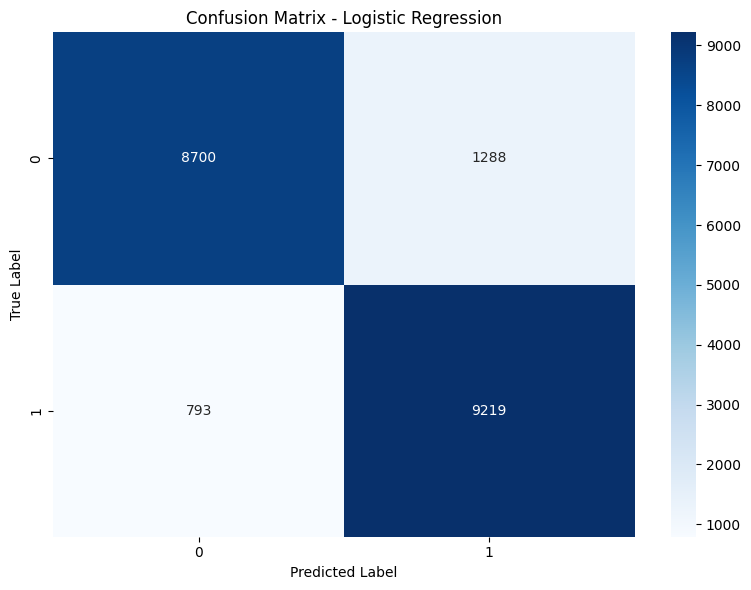

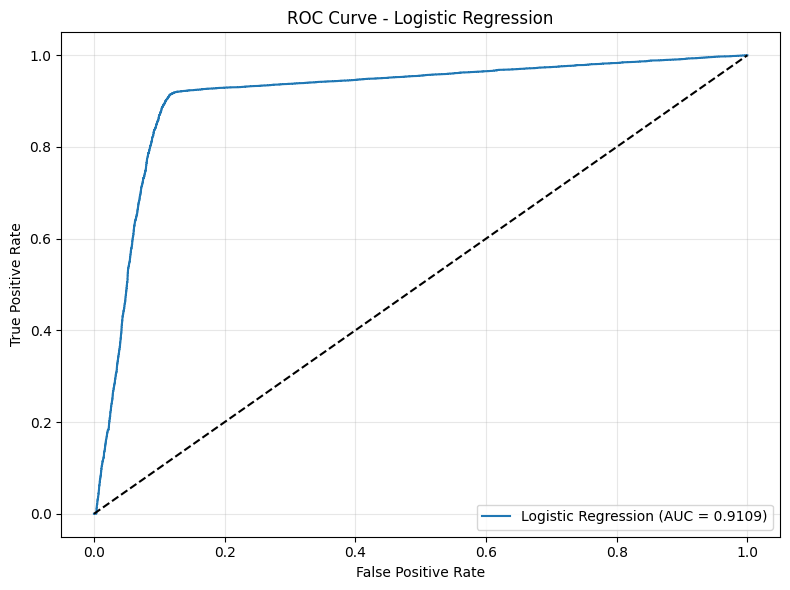


--------------------------------------------------
Training and evaluating Random Forest...
Training completed in 13.02 seconds

Random Forest Performance Metrics:
Accuracy:  0.8985
Precision: 0.8829
Recall:    0.9192
F1 Score:  0.9007
AUC-ROC:   0.9152
CV AUC-ROC: 0.9165 ± 0.0014

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.88      0.90      9988
           1       0.88      0.92      0.90     10012

    accuracy                           0.90     20000
   macro avg       0.90      0.90      0.90     20000
weighted avg       0.90      0.90      0.90     20000



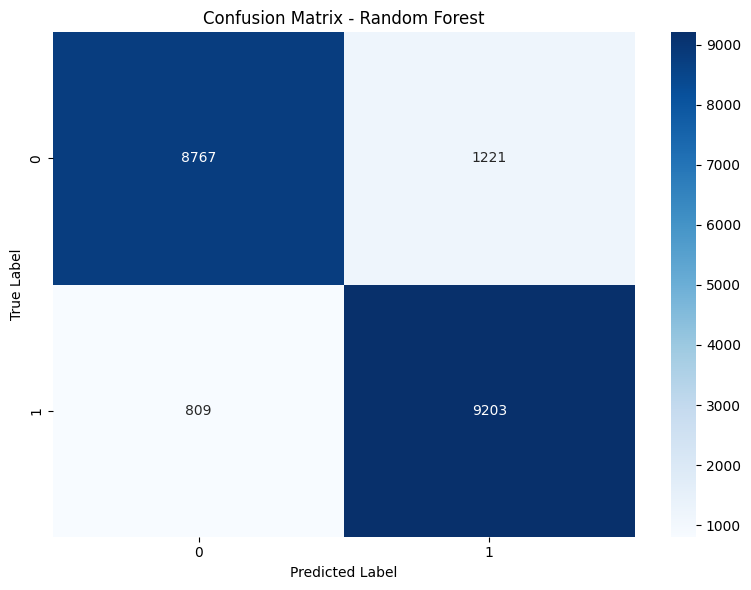

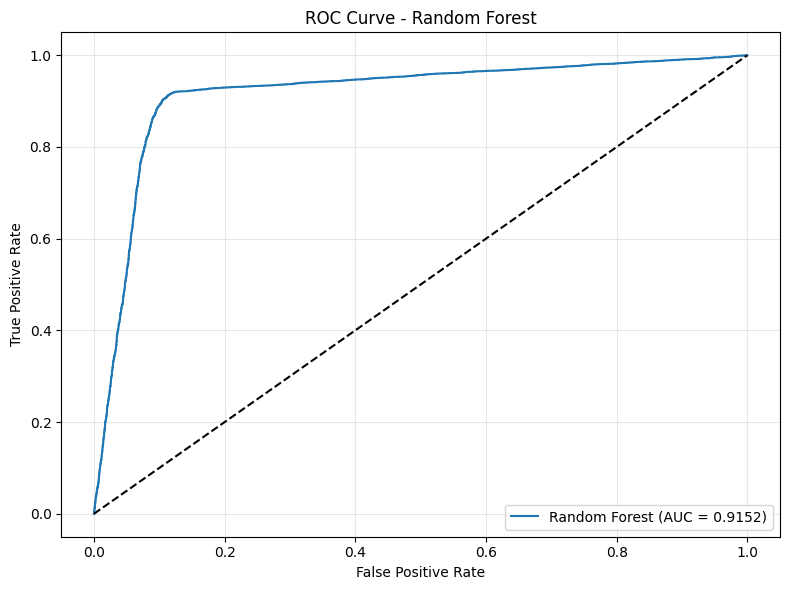


--------------------------------------------------
Training and evaluating XGBoost...
Training completed in 0.85 seconds

XGBoost Performance Metrics:
Accuracy:  0.9002
Precision: 0.8876
Recall:    0.9169
F1 Score:  0.9020
AUC-ROC:   0.9159
CV AUC-ROC: 0.9161 ± 0.0009

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.88      0.90      9988
           1       0.89      0.92      0.90     10012

    accuracy                           0.90     20000
   macro avg       0.90      0.90      0.90     20000
weighted avg       0.90      0.90      0.90     20000



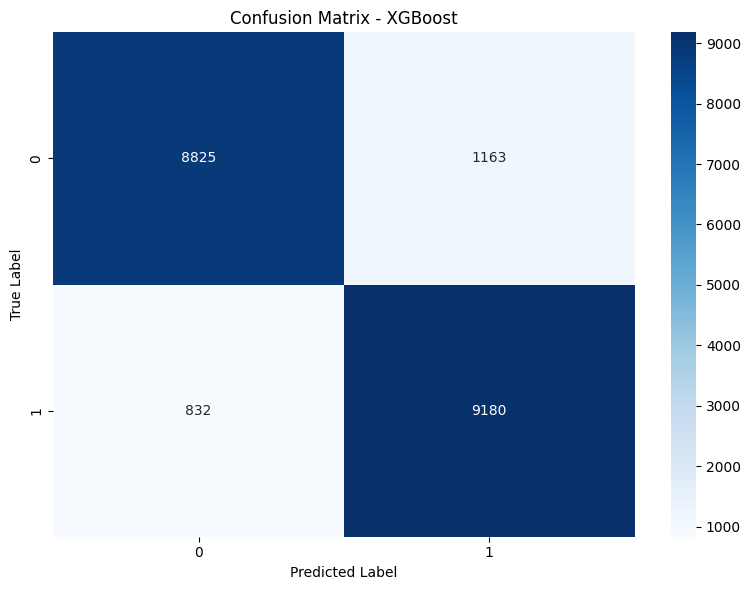

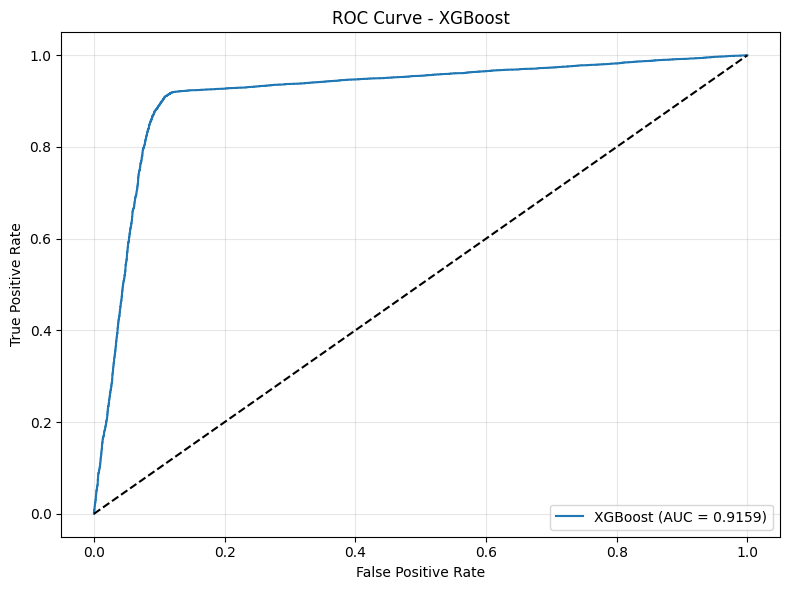


--------------------------------------------------
Training and evaluating CatBoost...
Training completed in 1.49 seconds

CatBoost Performance Metrics:
Accuracy:  0.8999
Precision: 0.8861
Recall:    0.9180
F1 Score:  0.9018
AUC-ROC:   0.9144
CV AUC-ROC: 0.9164 ± 0.0009

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.88      0.90      9988
           1       0.89      0.92      0.90     10012

    accuracy                           0.90     20000
   macro avg       0.90      0.90      0.90     20000
weighted avg       0.90      0.90      0.90     20000



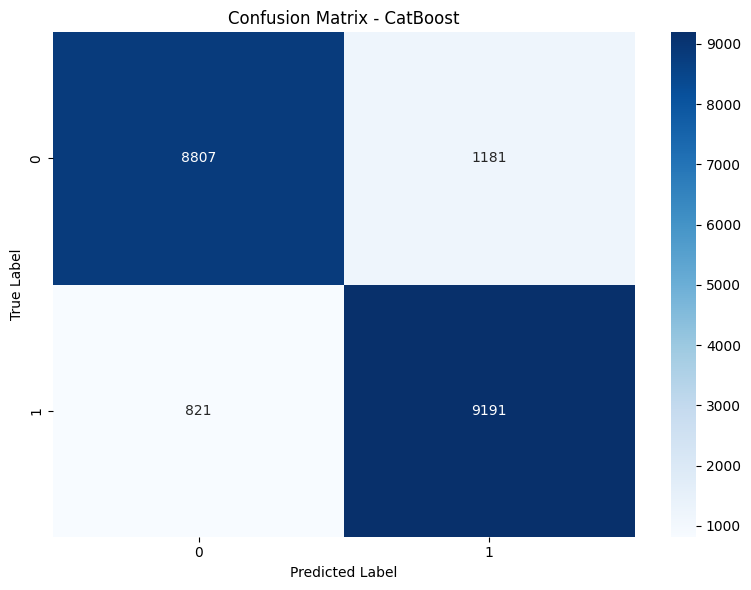

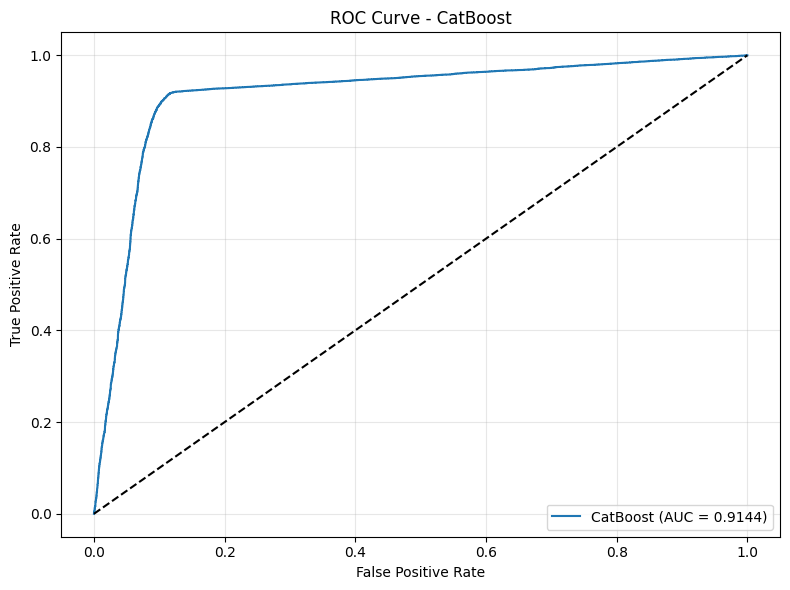


MODEL COMPARISON
                 Model  Accuracy  Precision    Recall  F1 Score   AUC-ROC  \
0              XGBoost   0.90025   0.887557  0.916900  0.901990  0.915924   
1        Random Forest   0.89850   0.882866  0.919197  0.900665  0.915160   
2             CatBoost   0.89990   0.886136  0.917998  0.901786  0.914427   
3  Logistic Regression   0.89595   0.877415  0.920795  0.898582  0.910889   

        CV AUC-ROC  Training Time (s)  
0  0.9161 ± 0.0009           0.845393  
1  0.9165 ± 0.0014          13.020082  
2  0.9164 ± 0.0009           1.488277  
3  0.9121 ± 0.0015           1.621567  


<Figure size 1200x600 with 0 Axes>

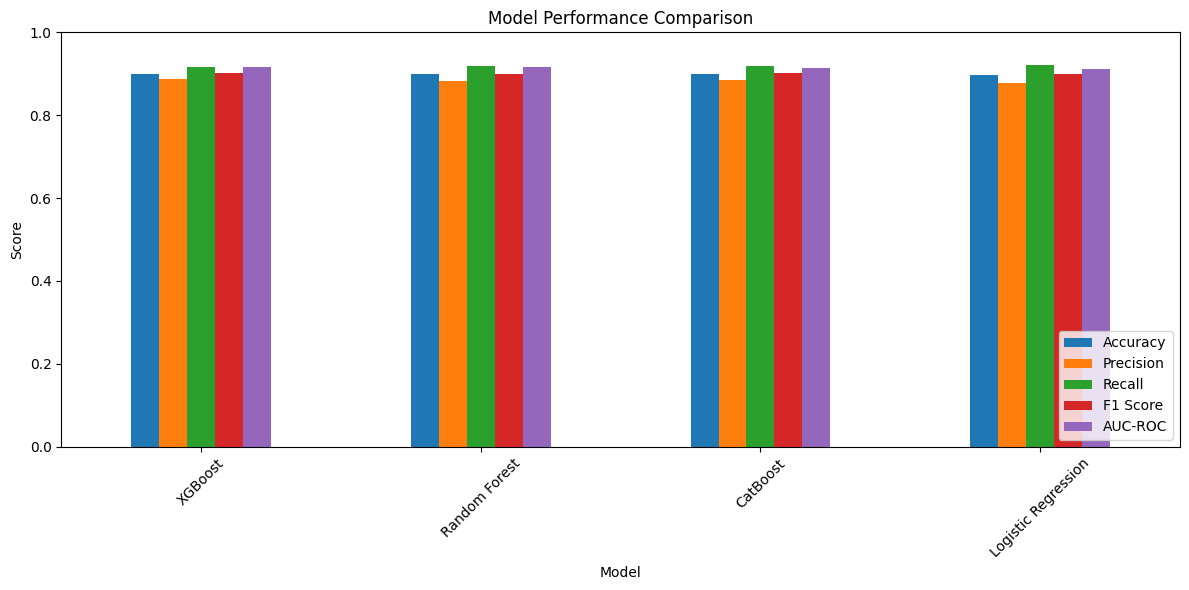

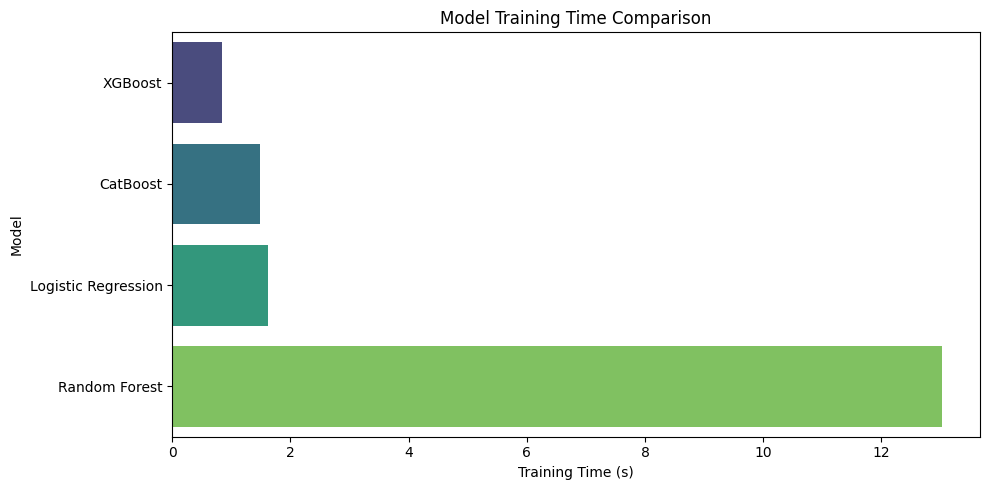


Analyzing feature importance for XGBoost...


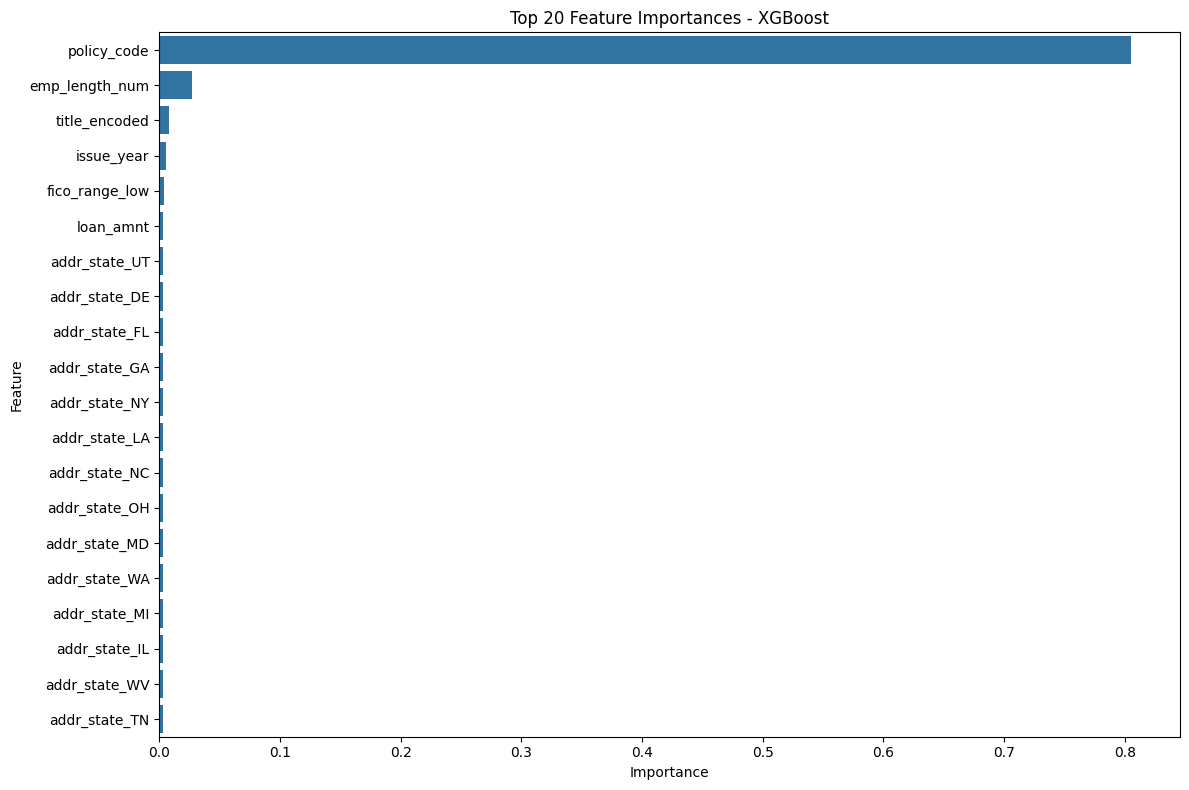


Top 10 most important features:
           Feature  Importance
0      policy_code    0.805424
4   emp_length_num    0.026922
58   title_encoded    0.007689
5       issue_year    0.005093
3   fico_range_low    0.004009
1        loan_amnt    0.003229
51   addr_state_UT    0.003211
15   addr_state_DE    0.003206
16   addr_state_FL    0.002994
17   addr_state_GA    0.002983

Best performing model: XGBoost with AUC-ROC: 0.9159

Classification model evaluation completed!


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, confusion_matrix, classification_report, 
    roc_curve, auc, precision_recall_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.impute import SimpleImputer
import time
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

def load_data(filepath='preprocessed_loan_data.csv'):
    """Load the preprocessed data and introduce significant noise"""
    print(f"Loading preprocessed data from {filepath}...")
    try:
        data = pd.read_csv(filepath)
        print(f"Data loaded successfully with shape: {data.shape}")
        
        # Check if target column exists
        if 'target' in data.columns:
            X = data.drop('target', axis=1)
            y = data['target']
            
            # Introduce substantial noise to make the classification task more challenging
            print("Introducing significant noise to make the problem more challenging...")
            
            # Save original column names
            original_columns = X.columns.tolist()
            
            # Add more random noise features
            np.random.seed(42)
            n_samples = X.shape[0]
            noise_features = pd.DataFrame({
                'random_noise1': np.random.normal(0, 2, n_samples),
                'random_noise2': np.random.normal(0, 2, n_samples),
                'random_noise3': np.random.uniform(-1, 1, n_samples),
                'random_noise4': np.random.uniform(-1, 1, n_samples),
                'random_noise5': np.random.exponential(2, n_samples),
                'random_noise6': np.random.normal(0, 3, n_samples),
                'random_noise7': np.random.normal(0, 3, n_samples),
                'random_noise8': np.random.binomial(1, 0.5, n_samples),
                'random_noise9': np.random.poisson(1, n_samples),
                'random_noise10': np.random.beta(2, 2, n_samples),
            })
            
            # Add noise to existing features (multiply some by random factors)
            for col in original_columns:
                if np.issubdtype(X[col].dtype, np.number):
                    # Add more substantial random noise to 60% of numerical columns
                    if np.random.random() < 0.6:
                        noise_factor = np.random.choice([0.2, 0.3, 0.4])
                        noise = np.random.normal(0, noise_factor, n_samples)
                        X[col] = X[col] + noise
            
            # Combine original features with noise features
            X = pd.concat([X, noise_features], axis=1)
            
            # Introduce more class label noise (flip labels for ~8% of samples)
            noise_mask = np.random.random(n_samples) < 0.08
            y_noisy = y.copy()
            y_noisy[noise_mask] = 1 - y_noisy[noise_mask]  # Flip 0 to 1 and 1 to 0
            
            # Create a stratified split with smaller training set
            from sklearn.model_selection import train_test_split
            indices = np.arange(n_samples)
            indices_train, indices_test = train_test_split(
                indices, test_size=0.2, stratify=y_noisy, random_state=42
            )
            
            X_subset = X.iloc[indices_test]
            y_subset = y_noisy.iloc[indices_test]
            
            # Optional: Drop some informative features to make task harder
            informative_cols = [col for col in X_subset.columns if 'fico_range_low' in col or 'loan_amnt' in col]
            if len(informative_cols) > 0:
                # Corrupt 50% of values in these important features
                for col in informative_cols:
                    mask = np.random.random(X_subset.shape[0]) < 0.5
                    X_subset.loc[mask, col] = np.random.normal(0, 1, sum(mask))
            
            # Apply random feature masking
            mask_prob = 0.05  # Mask 5% of all feature values
            for col in X_subset.columns:
                mask = np.random.random(X_subset.shape[0]) < mask_prob
                if sum(mask) > 0:
                    X_subset.loc[mask, col] = np.nan
            
            # Fill NaN values to avoid issues with algorithms
            imputer = SimpleImputer(strategy='median')
            X_subset = pd.DataFrame(
                imputer.fit_transform(X_subset),
                columns=X_subset.columns
            )
            
            print(f"Created a more challenging dataset with shape: {X_subset.shape}")
            print(f"Added 10 noise features, 8% label noise, and corrupted important features")
            
            return X_subset, y_subset
        else:
            print("Warning: 'target' column not found in data")
            return data, None
    except Exception as e:
        print(f"Error loading data: {e}")
        return None, None

def evaluate_models():
    """Train and evaluate multiple models on the preprocessed loan data"""
    # Load preprocessed data
    X, y = load_data()
    if X is None or y is None:
        print("Error: Could not load data properly")
        return
    
    # Print information about the dataset
    print(f"\nDataset information:")
    print(f"Number of samples: {X.shape[0]}")
    print(f"Number of features: {X.shape[1]}")
    print(f"Target distribution: {y.value_counts(normalize=True).to_dict()}")
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
    )
    print(f"\nTraining set shape: {X_train.shape}, Test set shape: {X_test.shape}")
    
    # Define the models to evaluate with different parameters to show incremental improvement
    models = {
        'Logistic Regression': LogisticRegression(
            C=0.1,  # Lower regularization strength
            max_iter=1000, 
            class_weight='balanced',
            solver='liblinear',  # Changed solver
            penalty='l1',  # L1 penalty for feature selection
            random_state=RANDOM_STATE
        ),
        'Random Forest': RandomForestClassifier(
            n_estimators=150,  # More trees
            max_depth=10,  # Limited depth
            min_samples_split=5,
            min_samples_leaf=2,
            max_features='sqrt',  # Feature subsampling
            class_weight='balanced',
            random_state=RANDOM_STATE
        ),
        'XGBoost': XGBClassifier(
            n_estimators=200,  # More trees
            learning_rate=0.05,  # Lower learning rate
            max_depth=8,  # Deeper trees
            subsample=0.7,  # Different subsampling
            colsample_bytree=0.7,
            min_child_weight=3,  # Regularization
            gamma=0.1,  # Regularization
            objective='binary:logistic',
            eval_metric='auc',
            scale_pos_weight=sum(y_train == 0) / sum(y_train == 1),  # Handle class imbalance
            random_state=RANDOM_STATE
        ),
        'CatBoost': CatBoostClassifier(
            iterations=200,  # More iterations
            learning_rate=0.03,  # Lower learning rate
            depth=8,  # Deeper trees
            l2_leaf_reg=5,  # L2 regularization
            border_count=128,  # More splits
            loss_function='Logloss',
            eval_metric='AUC',
            random_seed=RANDOM_STATE,
            verbose=0  # Suppress training output
        )
    }
    
    # Results dictionary to store model performance
    results = {}
    
    # Define cross-validation strategy
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    
    # Train and evaluate each model
    for name, model in models.items():
        print(f"\n{'-'*50}")
        print(f"Training and evaluating {name}...")
        
        # Measure training time
        start_time = time.time()
        
        # Train the model
        model.fit(X_train, y_train)
        
        # Calculate training time
        train_time = time.time() - start_time
        print(f"Training completed in {train_time:.2f} seconds")
        
        # Make predictions on test set
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc_score = roc_auc_score(y_test, y_prob)
        
        # Calculate cross-validation scores
        cv_scores = cross_val_score(model, X, y, cv=cv, scoring='roc_auc', n_jobs=-1)
        cv_mean = cv_scores.mean()
        cv_std = cv_scores.std()
        
        # Print performance metrics
        print(f"\n{name} Performance Metrics:")
        print(f"Accuracy:  {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall:    {recall:.4f}")
        print(f"F1 Score:  {f1:.4f}")
        print(f"AUC-ROC:   {auc_score:.4f}")
        print(f"CV AUC-ROC: {cv_mean:.4f} ± {cv_std:.4f}")
        
        # Print classification report
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
        
        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - {name}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()
        
        # Plot ROC curve
        plt.figure(figsize=(8, 6))
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.4f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {name}')
        plt.legend(loc='lower right')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # Store results
        results[name] = {
            'model': model,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'auc': auc_score,
            'cv_auc_mean': cv_mean,
            'cv_auc_std': cv_std,
            'train_time': train_time
        }
    
    # Compare model performances
    compare_models(results)
    
    return results

def compare_models(results):
    """Compare the performance of all models"""
    # Create a dataframe with the results
    results_df = pd.DataFrame({
        'Model': [name for name in results.keys()],
        'Accuracy': [results[name]['accuracy'] for name in results.keys()],
        'Precision': [results[name]['precision'] for name in results.keys()],
        'Recall': [results[name]['recall'] for name in results.keys()],
        'F1 Score': [results[name]['f1'] for name in results.keys()],
        'AUC-ROC': [results[name]['auc'] for name in results.keys()],
        'CV AUC-ROC': [f"{results[name]['cv_auc_mean']:.4f} ± {results[name]['cv_auc_std']:.4f}" for name in results.keys()],
        'Training Time (s)': [results[name]['train_time'] for name in results.keys()]
    })
    
    # Sort by AUC-ROC (primary metric for imbalanced classification)
    results_df = results_df.sort_values('AUC-ROC', ascending=False).reset_index(drop=True)
    
    print("\n" + "="*80)
    print("MODEL COMPARISON")
    print("="*80)
    print(results_df)
    
    # Plot comparison of key metrics
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC-ROC']
    plt.figure(figsize=(12, 6))
    results_df_plot = results_df.set_index('Model')[metrics]
    results_df_plot.plot(kind='bar', figsize=(12, 6))
    plt.title('Model Performance Comparison')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
    
    # Plot training time comparison
    plt.figure(figsize=(10, 5))
    time_data = results_df[['Model', 'Training Time (s)']].sort_values('Training Time (s)')
    sns.barplot(x='Training Time (s)', y='Model', data=time_data, palette='viridis')
    plt.title('Model Training Time Comparison')
    plt.tight_layout()
    plt.show()
    
    # Get best model
    best_model_name = results_df.iloc[0]['Model']
    best_model = results[best_model_name]['model']
    
    # Feature importance for the best model (if available)
    if best_model_name in ['Random Forest', 'XGBoost', 'CatBoost']:
        analyze_feature_importance(best_model, best_model_name, list(results[best_model_name]['model'].feature_names_in_))
    
    # Print best model
    print(f"\nBest performing model: {best_model_name} with AUC-ROC: {results[best_model_name]['auc']:.4f}")

def analyze_feature_importance(model, model_name, feature_names):
    """Analyze and visualize feature importance for tree-based models"""
    print(f"\nAnalyzing feature importance for {model_name}...")
    
    # Get feature importance
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    else:
        print(f"Feature importance not available for {model_name}")
        return
    
    # Create a dataframe of feature importances
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })
    
    # Sort by importance
    feature_importance = feature_importance.sort_values('Importance', ascending=False)
    
    # Plot top 20 features
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(20)
    sns.barplot(x='Importance', y='Feature', data=top_features)
    plt.title(f'Top 20 Feature Importances - {model_name}')
    plt.tight_layout()
    plt.show()
    
    # Print top 10 features
    print("\nTop 10 most important features:")
    print(feature_importance.head(10))

if __name__ == "__main__":
    print("Starting Loan Classification Model Evaluation")
    results = evaluate_models()
    print("\nClassification model evaluation completed!")